In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

In [4]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")

CUDA is available.


In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ===========================
# Data augmentation and loading
# ===========================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load full training set
full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Split into 40k train and 10k validation
train_size = 40000
val_size = 10000
train_subset, val_subset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

# Data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2)

# Test set remains unchanged
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# ===========================
# Experiment tracking class
# ===========================
class ExperimentTracker:
    def __init__(self):
        self.results = defaultdict(list)

    def log(self, experiment_name, epoch, train_loss, train_acc, val_loss, val_acc):
        self.results[experiment_name].append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    def plot_comparison(self, experiment_names, title="Training Comparison", save_path=None):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

        for i, exp_name in enumerate(experiment_names):
            if exp_name not in self.results:
                continue

            data = self.results[exp_name]
            epochs = [d['epoch'] for d in data]
            train_losses = [d['train_loss'] for d in data]
            val_losses = [d['val_loss'] for d in data]
            train_accs = [d['train_acc'] for d in data]
            val_accs = [d['val_acc'] for d in data]

            color = colors[i % len(colors)]

            axes[0,0].plot(epochs, train_losses, label=f'{exp_name}', linewidth=2, color=color)
            axes[0,1].plot(epochs, val_losses, label=f'{exp_name}', linewidth=2, color=color)
            axes[1,0].plot(epochs, train_accs, label=f'{exp_name}', linewidth=2, color=color)
            axes[1,1].plot(epochs, val_accs, label=f'{exp_name}', linewidth=2, color=color)

        axes[0,0].set_title('Training Loss')
        axes[0,1].set_title('Validation Loss')
        axes[1,0].set_title('Training Accuracy')
        axes[1,1].set_title('Validation Accuracy')
        for ax in axes.flat:
            ax.set_xlabel('Epoch')
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def get_final_results(self, experiment_name):
        if experiment_name in self.results and self.results[experiment_name]:
            return self.results[experiment_name][-1]
        return None

# Initialize tracker
tracker = ExperimentTracker()

# ===========================
# Custom Batch Normalization (Section 6)
# ===========================


class CustomBatchNorm2d(nn.Module):
    """
    Custom BatchNorm2d where mean and variance do NOT participate in gradient calculation.

    Key difference from PyTorch's BatchNorm:
    - PyTorch: Gradients flow through batch statistics (mean and variance)
    - Custom: batch_mean and batch_var are computed, then DETACHED from graph

    This follows the assignment requirement: "use the detach() function"
    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(CustomBatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Learnable parameters (γ and β)
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))

        # Running statistics (buffers, not parameters)
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def forward(self, x):
        if self.training:
            batch_mean = x.mean(dim=[0, 2, 3])
            batch_mean_detached = batch_mean.detach()

            batch_var = ((x - batch_mean_detached.view(1, -1, 1, 1)) ** 2).mean(dim=[0, 2, 3])
            batch_var_detached = batch_var.detach()

            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean_detached
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var_detached
                self.num_batches_tracked += 1

            x_norm = (x - batch_mean_detached.view(1, -1, 1, 1)) / \
                    torch.sqrt(batch_var_detached.view(1, -1, 1, 1) + self.eps)
        else:
            x_norm = (x - self.running_mean.view(1, -1, 1, 1)) / \
                    torch.sqrt(self.running_var.view(1, -1, 1, 1) + self.eps)

        return self.weight.view(1, -1, 1, 1) * x_norm + self.bias.view(1, -1, 1, 1)


# ===========================
# ResNet Architecture
# ===========================
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, use_custom_bn=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = CustomBatchNorm2d(planes) if use_custom_bn else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = CustomBatchNorm2d(planes) if use_custom_bn else nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                CustomBatchNorm2d(self.expansion*planes) if use_custom_bn else nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_custom_bn=False):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.use_custom_bn = use_custom_bn
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = CustomBatchNorm2d(64) if use_custom_bn else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.use_custom_bn))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return self.linear(out)

def ResNet18(use_custom_bn=False):
    return ResNet(BasicBlock, [2, 2, 2, 2], use_custom_bn=use_custom_bn)

# ===========================
# Training and validation functions
# ===========================
def train(epoch, net, criterion, trainloader, scheduler, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    if scheduler and not isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

def validate(epoch, net, criterion, valloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return val_loss/(batch_idx+1), 100.*correct/total

100%|██████████| 170M/170M [00:14<00:00, 11.7MB/s] 


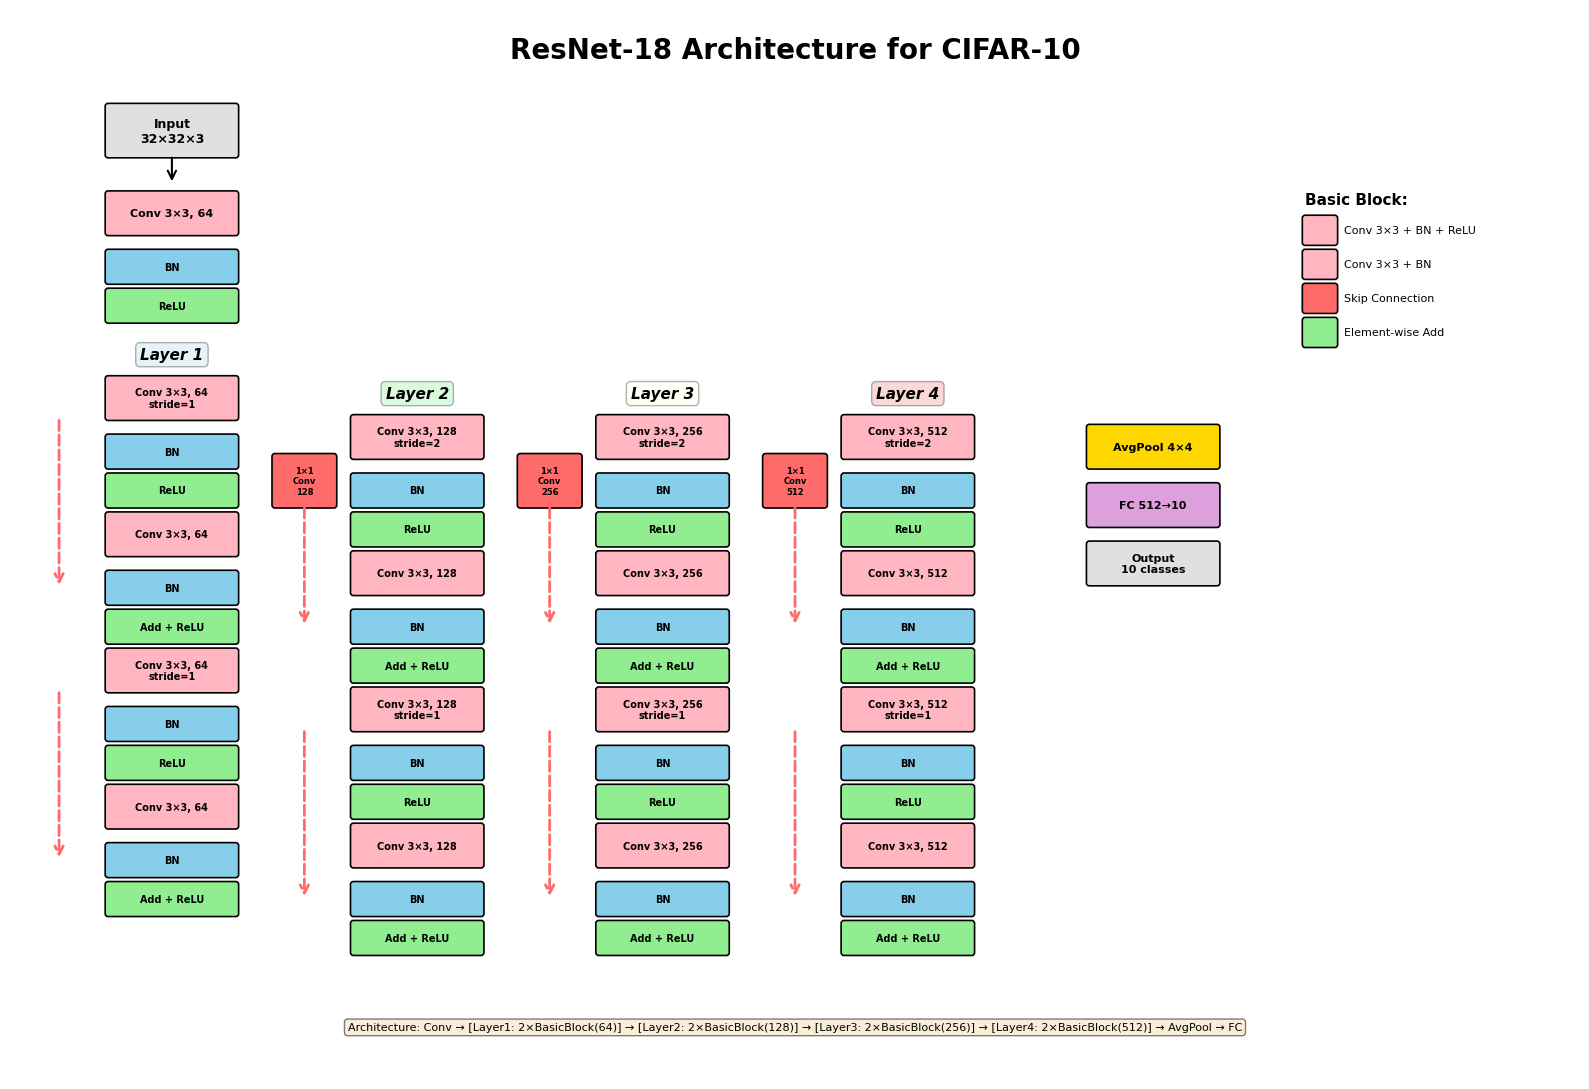

In [6]:

def visualize_resnet_architecture():
    """
    Generate a clean and consistent ResNet-18 architecture diagram for Section 2
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Rectangle

    fig, ax = plt.subplots(figsize=(16, 11))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 11)
    ax.axis('off')

    # Title
    ax.text(8, 10.5, 'ResNet-18 Architecture for CIFAR-10', fontsize=20, fontweight='bold', ha='center')

    # Define colors
    color_conv = '#FFB6C1'
    color_bn = '#87CEEB'
    color_relu = '#90EE90'
    color_pool = '#FFD700'
    color_fc = '#DDA0DD'
    color_residual = '#FF6B6B'

    # Helper function to draw block
    def draw_block(x, y, width, height, color, label, fontsize=8):
        box = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.03",
                            edgecolor='black', facecolor=color, linewidth=1.2)
        ax.add_patch(box)
        ax.text(x + width/2, y + height/2, label, ha='center', va='center',
               fontsize=fontsize, fontweight='bold', wrap=True)

    def draw_arrow(x1, y1, x2, y2, color='black', style='-', width=1.5):
        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                              arrowstyle='->', mutation_scale=15, linewidth=width,
                              color=color, linestyle=style)
        ax.add_patch(arrow)

    # Starting position
    x_pos = 1
    y_start = 9.5
    block_width = 1.3
    block_height = 0.4

    # Input
    draw_block(x_pos, y_start, block_width, 0.5, '#E0E0E0', 'Input\n32×32×3', 9)
    draw_arrow(x_pos + block_width/2, y_start, x_pos + block_width/2, y_start - 0.3, 'black')

    # Initial Conv Block
    y_pos = y_start - 0.8
    draw_block(x_pos, y_pos, block_width, block_height, color_conv, 'Conv 3×3, 64', 8)
    y_pos -= 0.5
    draw_block(x_pos, y_pos, block_width, 0.3, color_bn, 'BN', 7)
    y_pos -= 0.4
    draw_block(x_pos, y_pos, block_width, 0.3, color_relu, 'ReLU', 7)

    # Function to draw a residual block
    def draw_residual_block(x, y, channels, stride=1, has_projection=False):
        block_start_y = y

        # Main path
        draw_block(x, y, block_width, block_height, color_conv, f'Conv 3×3, {channels}\nstride={stride}', 7)
        y -= 0.5
        draw_block(x, y, block_width, 0.3, color_bn, 'BN', 7)
        y -= 0.4
        draw_block(x, y, block_width, 0.3, color_relu, 'ReLU', 7)
        y -= 0.5
        draw_block(x, y, block_width, block_height, color_conv, f'Conv 3×3, {channels}', 7)
        y -= 0.5
        draw_block(x, y, block_width, 0.3, color_bn, 'BN', 7)

        # Skip connection
        skip_x = x - 0.8
        if has_projection:
            # Draw projection shortcut
            proj_y = block_start_y - 0.5
            draw_block(skip_x, proj_y, 0.6, 0.5, color_residual, f'1×1\nConv\n{channels}', 6)
            draw_arrow(skip_x + 0.3, block_start_y, skip_x + 0.3, proj_y + 0.5, color_residual, '--', 2)
            draw_arrow(skip_x + 0.3, proj_y, skip_x + 0.3, y + 0.15, color_residual, '--', 2)
        else:
            # Identity shortcut
            draw_arrow(skip_x + 0.3, block_start_y, skip_x + 0.3, y + 0.15, color_residual, '--', 2)

        # Addition and ReLU
        y -= 0.4
        draw_block(x, y, block_width, 0.3, color_relu, 'Add + ReLU', 7)

        return y - 0.5

    # Layer 1: 2 blocks, 64 channels
    y_pos -= 0.6
    ax.text(x_pos + block_width/2, y_pos + 0.2, 'Layer 1', fontsize=11,
           ha='center', fontweight='bold', style='italic',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    y_pos -= 0.4

    y_pos = draw_residual_block(x_pos, y_pos, 64, stride=1, has_projection=False)
    y_pos = draw_residual_block(x_pos, y_pos, 64, stride=1, has_projection=False)

    # Layer 2: 2 blocks, 128 channels
    x_pos = 3.5
    y_pos = 9.5 - 0.8 - 0.5 - 0.4 - 0.6 - 0.4
    ax.text(x_pos + block_width/2, y_pos + 0.2, 'Layer 2', fontsize=11,
           ha='center', fontweight='bold', style='italic',
           bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    y_pos -= 0.4

    y_pos = draw_residual_block(x_pos, y_pos, 128, stride=2, has_projection=True)
    y_pos = draw_residual_block(x_pos, y_pos, 128, stride=1, has_projection=False)

    # Layer 3: 2 blocks, 256 channels
    x_pos = 6
    y_pos = 9.5 - 0.8 - 0.5 - 0.4 - 0.6 - 0.4
    ax.text(x_pos + block_width/2, y_pos + 0.2, 'Layer 3', fontsize=11,
           ha='center', fontweight='bold', style='italic',
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))
    y_pos -= 0.4

    y_pos = draw_residual_block(x_pos, y_pos, 256, stride=2, has_projection=True)
    y_pos = draw_residual_block(x_pos, y_pos, 256, stride=1, has_projection=False)

    # Layer 4: 2 blocks, 512 channels
    x_pos = 8.5
    y_pos = 9.5 - 0.8 - 0.5 - 0.4 - 0.6 - 0.4
    ax.text(x_pos + block_width/2, y_pos + 0.2, 'Layer 4', fontsize=11,
           ha='center', fontweight='bold', style='italic',
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
    y_pos -= 0.4

    y_pos = draw_residual_block(x_pos, y_pos, 512, stride=2, has_projection=True)
    y_pos = draw_residual_block(x_pos, y_pos, 512, stride=1, has_projection=False)

    # Final layers
    x_pos = 11
    y_pos = 9.5 - 0.8 - 0.5 - 0.4 - 0.6 - 0.4 - 0.5

    draw_block(x_pos, y_pos, block_width, 0.4, color_pool, 'AvgPool 4×4', 8)
    y_pos -= 0.6
    draw_block(x_pos, y_pos, block_width, 0.4, color_fc, 'FC 512→10', 8)
    y_pos -= 0.6
    draw_block(x_pos, y_pos, block_width, 0.4, '#E0E0E0', 'Output\n10 classes', 8)

    # Legend - Basic Block Structure
    legend_x = 13.2
    legend_y = 9
    ax.text(legend_x, legend_y, 'Basic Block:', fontsize=11, fontweight='bold')
    legend_y -= 0.4

    legend_items = [
        ('Conv 3×3 + BN + ReLU', color_conv),
        ('Conv 3×3 + BN', color_conv),
        ('Skip Connection', color_residual),
        ('Element-wise Add', color_relu),
    ]

    for item, color in legend_items:
        draw_block(legend_x, legend_y, 0.3, 0.25, color, '', 6)
        ax.text(legend_x + 0.4, legend_y + 0.125, item, fontsize=8, va='center')
        legend_y -= 0.35

    # Add architecture summary at bottom
    summary_y = 0.5
    summary_text = 'Architecture: Conv → [Layer1: 2×BasicBlock(64)] → [Layer2: 2×BasicBlock(128)] → [Layer3: 2×BasicBlock(256)] → [Layer4: 2×BasicBlock(512)] → AvgPool → FC'
    ax.text(8, summary_y, summary_text, fontsize=8, ha='center',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('resnet18_architecture.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    #print("✓ ResNet-18 architecture diagram saved as 'resnet18_architecture.png'")

# Call this function to generate the diagram
visualize_resnet_architecture()

Using device: cuda
SECTION 3: LEARNING RATE EXPERIMENTS

--- Testing Learning Rate: 0.1 ---
Epoch 5: Train Loss: 1.0388, Train Acc: 63.09%, Val Loss: 0.9904, Val Acc: 64.23%
Epoch 10: Train Loss: 0.5749, Train Acc: 79.92%, Val Loss: 0.6216, Val Acc: 78.09%
Epoch 15: Train Loss: 0.3903, Train Acc: 86.40%, Val Loss: 0.5021, Val Acc: 82.45%
Final - LR 0.1: Train Loss: 0.3903, Train Acc: 86.40%, Val Loss: 0.5021, Val Acc: 82.45%

--- Testing Learning Rate: 0.01 ---
Epoch 5: Train Loss: 0.5700, Train Acc: 80.11%, Val Loss: 0.6810, Val Acc: 76.32%
Epoch 10: Train Loss: 0.3594, Train Acc: 87.41%, Val Loss: 0.4584, Val Acc: 84.31%
Epoch 15: Train Loss: 0.2529, Train Acc: 91.05%, Val Loss: 0.4023, Val Acc: 87.03%
Final - LR 0.01: Train Loss: 0.2529, Train Acc: 91.05%, Val Loss: 0.4023, Val Acc: 87.03%

--- Testing Learning Rate: 0.001 ---
Epoch 5: Train Loss: 0.8335, Train Acc: 70.42%, Val Loss: 0.8332, Val Acc: 70.50%
Epoch 10: Train Loss: 0.5449, Train Acc: 80.65%, Val Loss: 0.5915, Val Acc: 

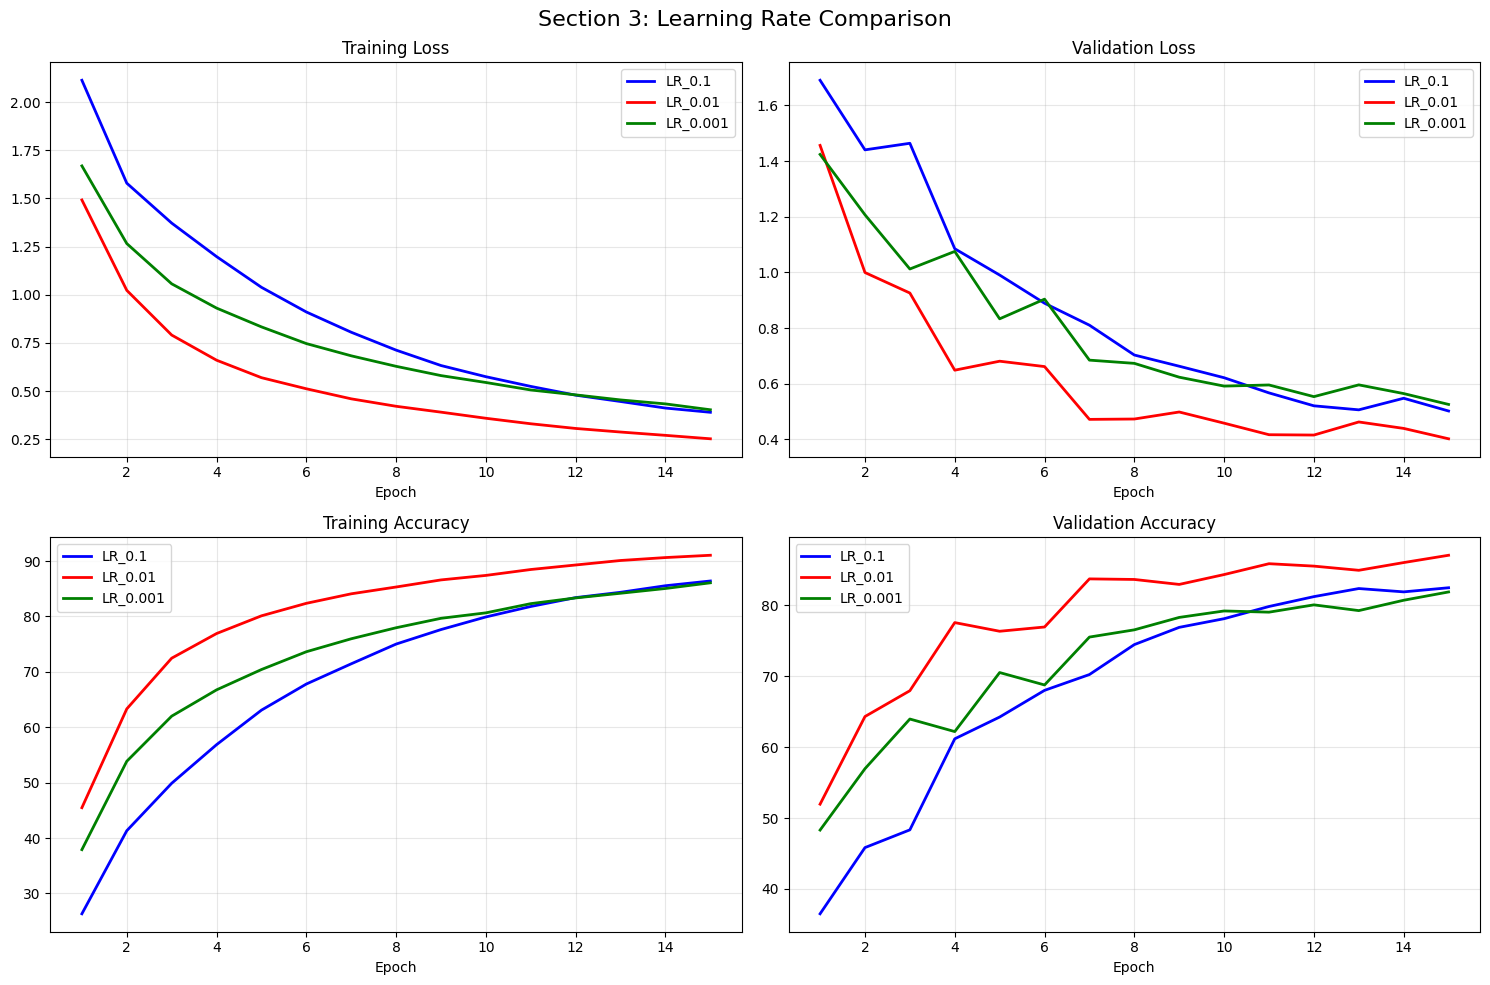


Best Learning Rate: 0.01

SECTION 4: LEARNING RATE SCHEDULING

--- Testing Scheduler: Constant_LR ---
Epoch 50: LR: 0.010000, Train Loss: 0.0379, Train Acc: 98.69%, Val Loss: 0.4253, Val Acc: 90.28%
Epoch 100: LR: 0.010000, Train Loss: 0.0091, Train Acc: 99.70%, Val Loss: 0.4501, Val Acc: 91.48%
Epoch 150: LR: 0.010000, Train Loss: 0.0030, Train Acc: 99.89%, Val Loss: 0.4519, Val Acc: 91.94%
Epoch 200: LR: 0.010000, Train Loss: 0.0008, Train Acc: 99.98%, Val Loss: 0.4821, Val Acc: 92.09%
Epoch 250: LR: 0.010000, Train Loss: 0.0022, Train Acc: 99.93%, Val Loss: 0.4836, Val Acc: 92.06%
Epoch 300: LR: 0.010000, Train Loss: 0.0012, Train Acc: 99.95%, Val Loss: 0.5272, Val Acc: 92.19%
Final - Constant_LR: Train Loss: 0.0012, Train Acc: 99.95%, Val Loss: 0.5272, Val Acc: 92.19%

--- Testing Scheduler: CosineAnnealing ---
Epoch 50: LR: 0.009330, Train Loss: 0.0387, Train Acc: 98.67%, Val Loss: 0.4154, Val Acc: 90.32%
Epoch 100: LR: 0.007500, Train Loss: 0.0047, Train Acc: 99.84%, Val Loss: 0

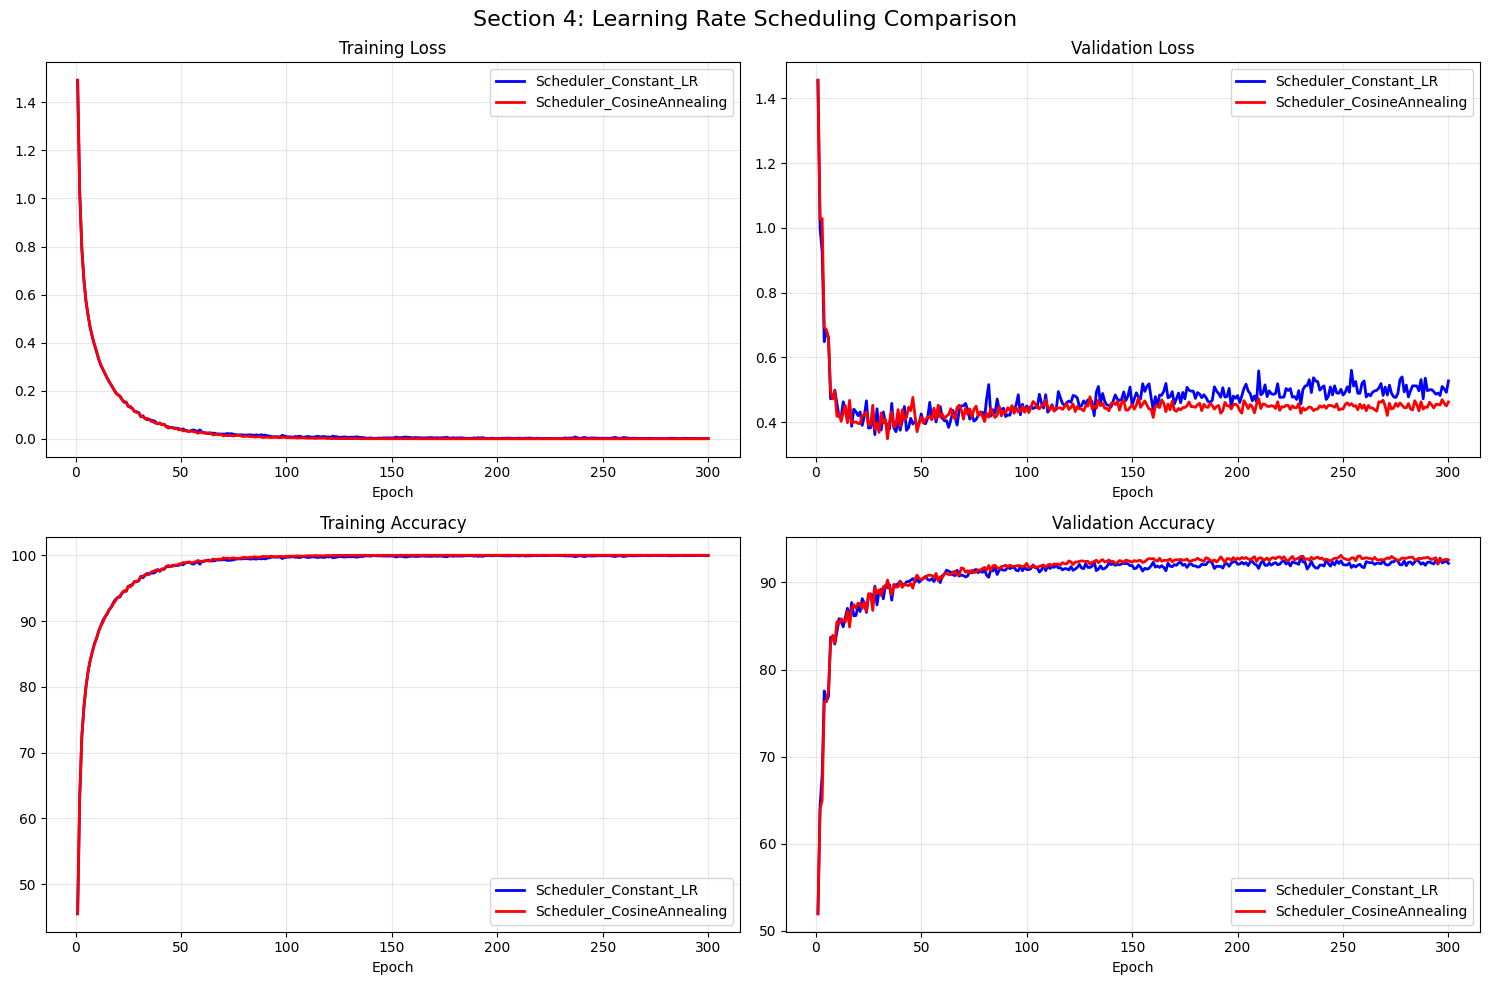


SECTION 5: WEIGHT DECAY EXPERIMENTS

--- Testing Weight Decay: 0.0005 ---
Epoch 50: Train Loss: 0.0615, Train Acc: 97.91%, Val Loss: 0.3267, Val Acc: 90.59%
Epoch 100: Train Loss: 0.0322, Train Acc: 98.98%, Val Loss: 0.3056, Val Acc: 91.39%
Epoch 150: Train Loss: 0.0097, Train Acc: 99.76%, Val Loss: 0.3019, Val Acc: 92.42%
Epoch 200: Train Loss: 0.0016, Train Acc: 99.99%, Val Loss: 0.2538, Val Acc: 93.58%
Epoch 250: Train Loss: 0.0012, Train Acc: 100.00%, Val Loss: 0.2357, Val Acc: 94.02%
Epoch 300: Train Loss: 0.0012, Train Acc: 100.00%, Val Loss: 0.2295, Val Acc: 93.97%
Final - WD 0.0005: Train Loss: 0.0012, Train Acc: 100.00%, Val Loss: 0.2295, Val Acc: 93.97%

--- Testing Weight Decay: 0.01 ---
Epoch 50: Train Loss: 0.4522, Train Acc: 85.31%, Val Loss: 0.6932, Val Acc: 75.88%
Epoch 100: Train Loss: 0.3931, Train Acc: 87.35%, Val Loss: 0.7072, Val Acc: 76.15%
Epoch 150: Train Loss: 0.3095, Train Acc: 90.39%, Val Loss: 0.4681, Val Acc: 84.72%
Epoch 200: Train Loss: 0.1843, Train Acc

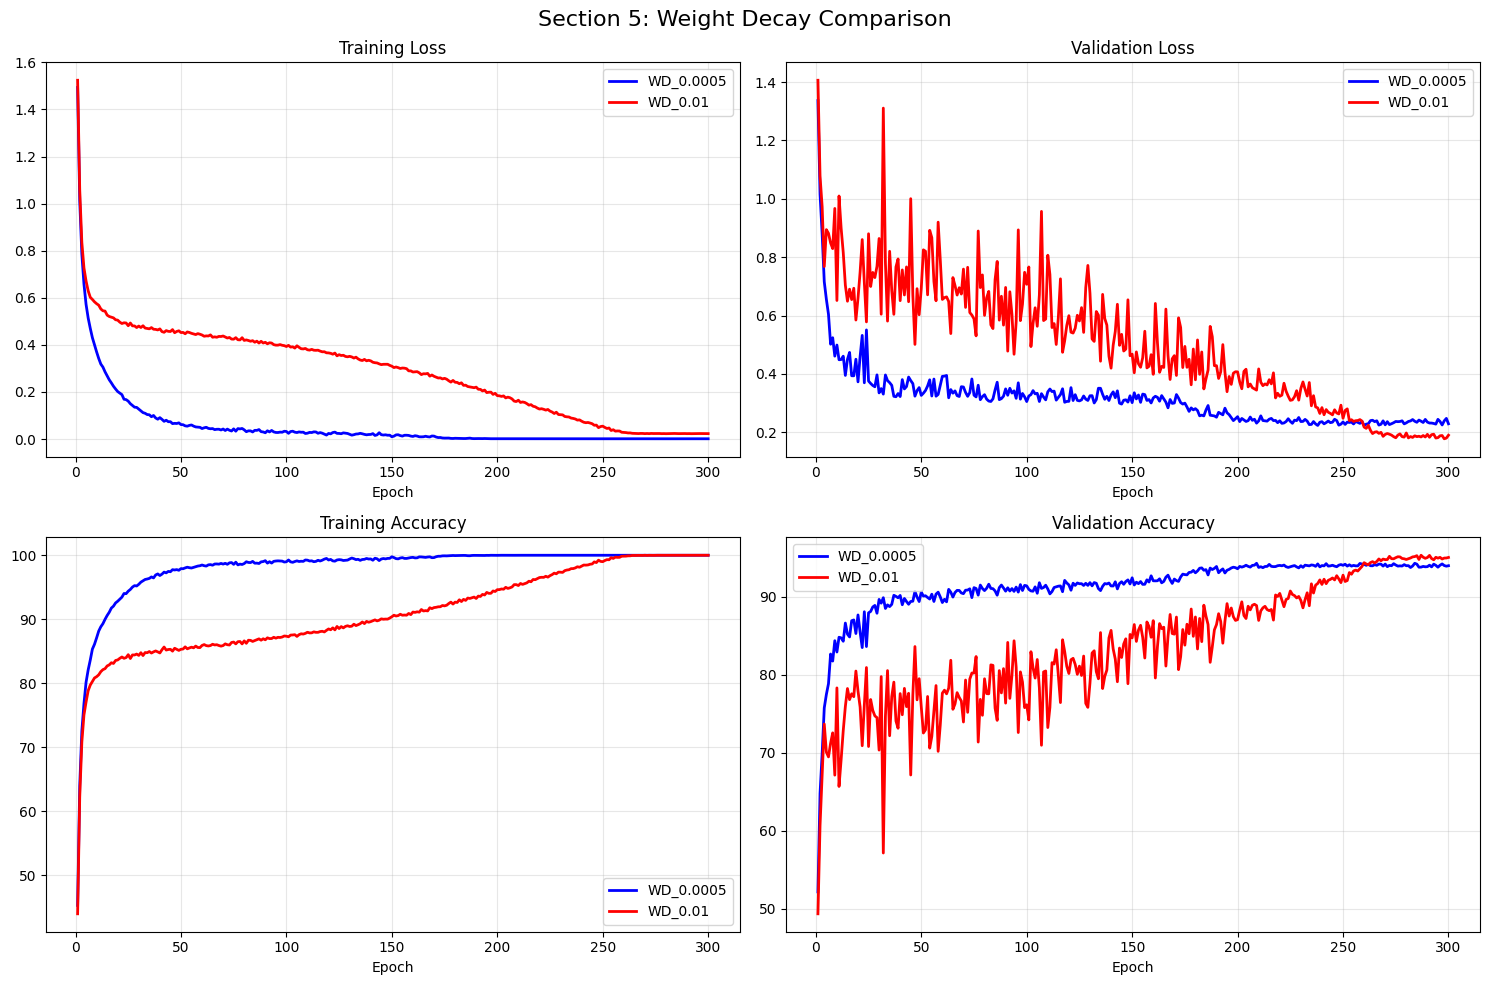


Best Weight Decay: 0.01

SECTION 6: CUSTOM BATCH NORMALIZATION

--- Testing: Standard_BN ---
Epoch 50: Train Loss: 0.4522, Train Acc: 85.31%, Val Loss: 0.6932, Val Acc: 75.88%
Epoch 100: Train Loss: 0.3931, Train Acc: 87.35%, Val Loss: 0.7072, Val Acc: 76.15%
Epoch 150: Train Loss: 0.3095, Train Acc: 90.39%, Val Loss: 0.4681, Val Acc: 84.72%
Epoch 200: Train Loss: 0.1843, Train Acc: 94.62%, Val Loss: 0.4073, Val Acc: 87.06%
Epoch 250: Train Loss: 0.0548, Train Acc: 99.00%, Val Loss: 0.2484, Val Acc: 92.76%
Epoch 300: Train Loss: 0.0231, Train Acc: 100.00%, Val Loss: 0.1903, Val Acc: 95.03%
Final - Standard_BN: Train Loss: 0.0231, Train Acc: 100.00%, Val Loss: 0.1903, Val Acc: 95.03%

--- Testing: Custom_BN ---
Epoch 50: Train Loss: 1.9725, Train Acc: 25.77%, Val Loss: 1.9999, Val Acc: 24.88%
Epoch 100: Train Loss: 1.9727, Train Acc: 25.95%, Val Loss: 2.0177, Val Acc: 24.19%
Epoch 150: Train Loss: 1.9849, Train Acc: 25.50%, Val Loss: 1.9845, Val Acc: 26.10%


In [ ]:
# ===========================
# Main experiments
# ===========================
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Section 3: Learning Rate Experiments
    print("=" * 60)
    print("SECTION 3: LEARNING RATE EXPERIMENTS")
    print("=" * 60)

    learning_rates = [0.1, 0.01, 0.001]
    lr_results = {}

    for lr in learning_rates:
        print(f"\n--- Testing Learning Rate: {lr} ---")
        set_seed(42)  # Reset seed for each experiment
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0)
        experiment_name = f'LR_{lr}'

        for epoch in range(1, 16):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, None, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)
            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        lr_results[lr] = final_result
        print(f"Final - LR {lr}: Train Loss: {final_result['train_loss']:.4f}, Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Loss: {final_result['val_loss']:.4f}, Val Acc: {final_result['val_acc']:.2f}%")

    # Plot learning rate comparison
    tracker.plot_comparison(['LR_0.1', 'LR_0.01', 'LR_0.001'],
                           "Section 3: Learning Rate Comparison",
                           save_path="lr_comparison.png")

    best_lr = max(lr_results.keys(), key=lambda x: lr_results[x]['val_acc'])
    print(f"\nBest Learning Rate: {best_lr}")


    # Section 4: Learning Rate Schedule
    print("\n" + "=" * 60)
    print("SECTION 4: LEARNING RATE SCHEDULING")
    print("=" * 60)

    # Constant LR vs Cosine Annealing
    schedulers = {
        'Constant_LR': None,
        'CosineAnnealing': optim.lr_scheduler.CosineAnnealingLR
    }

    scheduler_results = {}

    for sched_name in schedulers.keys():
        print(f"\n--- Testing Scheduler: {sched_name} ---")
        set_seed(42)
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=0)

        if sched_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
        else:
            scheduler = None

        experiment_name = f'Scheduler_{sched_name}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch}: LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        scheduler_results[sched_name] = final_result
        print(f"Final - {sched_name}: Train Loss: {final_result['train_loss']:.4f}, Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Loss: {final_result['val_loss']:.4f}, Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['Scheduler_Constant_LR', 'Scheduler_CosineAnnealing'],
                           "Section 4: Learning Rate Scheduling Comparison")

    # Section 5: Weight Decay
    print("\n" + "=" * 60)
    print("SECTION 5: WEIGHT DECAY EXPERIMENTS")
    print("=" * 60)

    weight_decays = [5e-4, 1e-2]
    wd_results = {}

    for wd in weight_decays:
        print(f"\n--- Testing Weight Decay: {wd} ---")
        set_seed(42)
        net = ResNet18().to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

        experiment_name = f'WD_{wd}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        wd_results[wd] = final_result
        print(f"Final - WD {wd}: Train Loss: {final_result['train_loss']:.4f}, Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Loss: {final_result['val_loss']:.4f}, Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['WD_0.0005', 'WD_0.01'],
                           "Section 5: Weight Decay Comparison")

    best_wd = max(wd_results.keys(), key=lambda x: wd_results[x]['val_acc'])
    print(f"\nBest Weight Decay: {best_wd}")

    # Section 6: Custom Batch Normalization
    print("\n" + "=" * 60)
    print("SECTION 6: CUSTOM BATCH NORMALIZATION")
    print("=" * 60)

    bn_types = [
        ('Standard_BN', False),
        ('Custom_BN', True)
    ]

    bn_results = {}

    for bn_name, use_custom in bn_types:
        print(f"\n--- Testing: {bn_name} ---")
        set_seed(42)
        net = ResNet18(use_custom_bn=use_custom).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

        experiment_name = f'BN_{bn_name}'

        for epoch in range(1, 301):
            train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
            val_loss, val_acc = validate(epoch, net, criterion, valloader)

            tracker.log(experiment_name, epoch, train_loss, train_acc, val_loss, val_acc)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        final_result = tracker.get_final_results(experiment_name)
        bn_results[bn_name] = final_result
        print(f"Final - {bn_name}: Train Loss: {final_result['train_loss']:.4f}, Train Acc: {final_result['train_acc']:.2f}%, "
              f"Val Loss: {final_result['val_loss']:.4f}, Val Acc: {final_result['val_acc']:.2f}%")

    tracker.plot_comparison(['BN_Standard_BN', 'BN_Custom_BN'],
                           "Section 6: Batch Normalization Comparison")

    best_bn = max(bn_results.keys(), key=lambda x: bn_results[x]['val_acc'])
    print(f"\nBest BatchNorm: {best_bn}")

    # Final Test Evaluation
    print("\n" + "=" * 60)
    print("FINAL TEST EVALUATION")
    print("=" * 60)

    print(f"\nBest Configuration:")
    print(f"Learning Rate: {best_lr}")
    print(f"Scheduler: CosineAnnealing")
    print(f"Weight Decay: {best_wd}")
    print(f"BatchNorm: {best_bn}")

    # Train final model with best configuration
    use_custom_bn = (best_bn == 'BN_Custom_BN')
    set_seed(42)
    final_net = ResNet18(use_custom_bn=use_custom_bn).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(final_net.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_wd)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

    print(f"\nTraining final model for 300 epochs...")
    best_val_acc = 0
    best_model_state = None

    for epoch in range(1, 301):
        train_loss, train_acc = train(epoch, final_net, criterion, trainloader, scheduler, optimizer)
        val_loss, val_acc = validate(epoch, final_net, criterion, valloader)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = final_net.state_dict().copy()

        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Load best model and evaluate on test set
    final_net.load_state_dict(best_model_state)

    print("\nFinal Test Evaluation:")
    test_loss, test_acc = validate(0, final_net, criterion, testloader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # Print all final results for easy copying to report
    print("\n" + "=" * 60)
    print("SUMMARY OF ALL FINAL RESULTS")
    print("=" * 60)

    experiments = [
        'LR_0.1', 'LR_0.01', 'LR_0.001',
        'Scheduler_Constant_LR', 'Scheduler_CosineAnnealing',
        'WD_0.0005', 'WD_0.01',
        'BN_Standard_BN', 'BN_Custom_BN'
    ]

    for exp_name in experiments:
        if exp_name in tracker.results:
            final = tracker.results[exp_name][-1]
            print(f"{exp_name}: Train Loss: {final['train_loss']:.4f}, Train Acc: {final['train_acc']:.2f}%, "
                  f"Val Loss: {final['val_loss']:.4f}, Val Acc: {final['val_acc']:.2f}%")

    print("\nAll experiments completed successfully!")